In [48]:
# PYTHON(MYENV_TEST)
#from time import sleep
import pandas as pd
import os
import glob
from datetime import datetime
from time import sleep

In [50]:
#pip install pyarrow

In [49]:
#pip install fastparquet

In [51]:
import pyarrow.parquet as pq
import fastparquet

In [57]:
class ChangeDataCapture:
    def __init__(self, timestamp) -> None:
        self.current_data = pd.DataFrame()
        self.previous_data = None
        self.source_file_name = None
        self.column_names = None
        self.timestamp = timestamp

    def load_current_data(self, file_path, file_name):
        self.current_data = pd.read_csv(file_path)
        self.source_file_name = file_name
        self.column_names = self.current_data.columns
        # Add snapshot timestamp and filename columns
        self.current_data['SnapshotTimestamp'] = self.timestamp
        self.current_data['SourceFileName'] = file_name

    def load_previous_data(self, snapshot_directory):
        if not os.path.exists(snapshot_directory):
            return False
        snapshot_subdirs = [d for d in os.listdir(snapshot_directory) if os.path.isdir(os.path.join(snapshot_directory, d))]
        if not snapshot_subdirs:
            return False
        latest_snapshot_dir = max(snapshot_subdirs, key=lambda d: os.path.getctime(os.path.join(snapshot_directory, d)))
        snapshot_files = glob.glob(os.path.join(snapshot_directory, latest_snapshot_dir, '*.parquet'))
        if not snapshot_files:
            return False
        self.previous_data = pd.read_parquet(snapshot_files[0], engine='pyarrow')
        return True

    def save_current_snapshot(self):
        snapshot_dir = os.path.join('snapshots', self.timestamp)
        os.makedirs(snapshot_dir, exist_ok=True)
        snapshot_file_path = os.path.join(snapshot_dir, 'snapshot.parquet')
        self.current_data.to_parquet(snapshot_file_path, index=False)

    def apply_cdc(self, remove_duplicates=True):
        self.current_data.drop_duplicates(keep='first', inplace=True)
        if self.previous_data is not None:
            combined_data = pd.concat([self.current_data, self.previous_data])
            if remove_duplicates:
                combined_data.drop_duplicates(subset=self.column_names, keep='last', inplace=True)
            self.current_data = combined_data



In [58]:
def run_cdc_pipeline(input_directory, snapshot_directory):
    os.chdir(input_directory)
    for file in glob.glob('data*.csv'):
        print(f'Processing File: {file}')
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        cdc = ChangeDataCapture(timestamp)
        cdc.load_current_data(os.path.join(input_directory, file), file)
        cdc.load_previous_data(snapshot_directory)
        cdc.apply_cdc(remove_duplicates=True)
        cdc.save_current_snapshot()
        sleep(1)

input_directory = r'C:/Users/Mirela Giantaru/OneDrive/Desktop/cdc_pipeline/'
snapshot_directory = r'C:/Users/Mirela Giantaru/OneDrive/Desktop/cdc_pipeline/snapshots/'
run_cdc_pipeline(input_directory, snapshot_directory)

Processing File: data_001.csv
Processing File: data_002.csv


##  To visualize the parquet file:

In [60]:
import pandas as pd

# Load the Parquet file
df = pd.read_parquet(r'C:/Users/Mirela Giantaru/OneDrive/Desktop/cdc_pipeline/snapshots/20240827000959/snapshot.parquet')
 
# Display the contents
print(df)


   id      name  age SnapshotTimestamp SourceFileName
0    1    Alice   31    20240827000746   data_002.csv
1    4    David   40    20240827000746   data_002.csv
2    1    Alice   30    20240827000745   data_001.csv
3    2      Bob   25    20240827000745   data_001.csv
4    3  Charlie   35    20240827000745   data_001.csv


In [61]:
df.describe()

,id,age
count,5.00000,5.000000
mean,2.20000,32.200000
std,1.30384,5.630275
min,1.00000,25.000000
25%,1.00000,30.000000
50%,2.00000,31.000000
75%,3.00000,35.000000
max,4.00000,40.000000


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5 non-null      int64 
 1   name               5 non-null      object
 2   age                5 non-null      int64 
 3   SnapshotTimestamp  5 non-null      object
 4   SourceFileName     5 non-null      object
dtypes: int64(2), object(3)
memory usage: 328.0+ bytes


##  Let's make some changes to the data and detect with this algorithm what changes have occurred

To identify which records have changed, the general approach is to compare the current snapshot with the previous one. The changes could include:

#Updated Records: Rows where some columns have changed.

#New Records: Rows that are present in the current snapshot but not in the previous one.

#Deleted Records (optional): Rows that were in the previous snapshot but are not in the current one (though the code currently does not track deletions).

In [63]:
import pandas as pd

def detect_changes(previous_df, current_df, primary_key):
    # Merge the old and new DataFrames on the primary key
    merged_df = previous_df.merge(current_df, on=primary_key, how='outer', suffixes=('_old', '_new'), indicator=True)
    #  The indicator=True option adds a column _merge that indicates where the records came from: 'left_only', 'right_only', or 'both'. 

    # Detect updated records
    # We check where _merge == 'both' and there are differences in any of the columns between the old and new DataFrames
    updated_records = merged_df[(merged_df['_merge'] == 'both') & 
                                (merged_df.filter(like='_old').ne(merged_df.filter(like='_new')).any(axis=1))]

    # Detect new records
    #  We check where _merge == 'right_only' to find records that are new.
    new_records = merged_df[merged_df['_merge'] == 'right_only']

    return updated_records, new_records


Because we have changed some data in the second csv file and we want to monitor the change, we will have to run again the initial code, the new dataframe  will be called current_df, 

In [64]:
previous_df = df

In [65]:
print(previous_df)

   id      name  age SnapshotTimestamp SourceFileName
0    1    Alice   31    20240827000746   data_002.csv
1    4    David   40    20240827000746   data_002.csv
2    1    Alice   30    20240827000745   data_001.csv
3    2      Bob   25    20240827000745   data_001.csv
4    3  Charlie   35    20240827000745   data_001.csv


In [66]:
# to obtain the current_df, we run again the cdc pipeline:
def run_cdc_pipeline(input_directory, snapshot_directory):
    os.chdir(input_directory)
    for file in glob.glob('data*.csv'):
        print(f'Processing File: {file}')
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        cdc = ChangeDataCapture(timestamp)
        cdc.load_current_data(os.path.join(input_directory, file), file)
        cdc.load_previous_data(snapshot_directory)
        cdc.apply_cdc(remove_duplicates=True)
        cdc.save_current_snapshot()
        sleep(1)

input_directory = r'C:/Users/Mirela Giantaru/OneDrive/Desktop/cdc_pipeline/'
snapshot_directory = r'C:/Users/Mirela Giantaru/OneDrive/Desktop/cdc_pipeline/snapshots/'
run_cdc_pipeline(input_directory, snapshot_directory)

Processing File: data_001.csv
Processing File: data_002.csv


In [67]:
#  the new directory is ...20240827030711 - which is the last subdirectory in the 'snapshots' directory, which will replace the old one: 20240827000959:
current_df = pd.read_parquet(r'C:/Users/Mirela Giantaru/OneDrive/Desktop/cdc_pipeline/snapshots/20240827030711/snapshot.parquet')
print(current_df)

    id      name  age SnapshotTimestamp SourceFileName
0     1    Alice   25    20240827030655   data_002.csv
1     2      Bob   29    20240827030655   data_002.csv
2     3  Charlie   45    20240827030655   data_002.csv
3     4    David   18    20240827030655   data_002.csv
4     6     Alex   55    20240827030655   data_002.csv
5     5    Bambi   22    20240827005356   data_002.csv
6     6     Alex   44    20240827005356   data_002.csv
7     7    Kevin   39    20240827005356   data_002.csv
8     1    Alice   31    20240827000746   data_002.csv
9     4    David   40    20240827000746   data_002.csv
10    1    Alice   30    20240827000745   data_001.csv
11    2      Bob   25    20240827000745   data_001.csv
12    3  Charlie   35    20240827000745   data_001.csv


In [69]:
# Below we can see the changes that occurred, I used as primary key the 'id' from the csv file, which acts as a primary key:
#updated_df, new_df = detect_changes(previous_df, current_df, primary_key='id')

# Display the results
#print("Updated Records:\n", updated_df)
#print("New Records:\n", new_df)

TO Detect Changes:

Merging DataFrames: We merge the previous and current DataFrames using the primary key (like id). The indicator=True option adds a column _merge that indicates where the records came from: 'left_only', 'right_only', or 'both'.
Updated Records: We check where _merge == 'both' and there are differences in any of the columns between the old and new DataFrames.
New Records: We check where _merge == 'right_only' to find records that are new.


In [70]:
print("Columns in previous_df:", previous_df.columns)
print("Columns in current_df:", current_df.columns)


Columns in previous_df: Index(['id ', 'name', 'age', 'SnapshotTimestamp', 'SourceFileName'], dtype='object')
Columns in current_df: Index(['id ', 'name', 'age', 'SnapshotTimestamp', 'SourceFileName'], dtype='object')


In [71]:
# Strip spaces from column names
previous_df.columns = previous_df.columns.str.strip()
current_df.columns = current_df.columns.str.strip()

# Now, you can use the detect_changes function
updated_df, new_df = detect_changes(previous_df, current_df, primary_key='id')

# Display the results
print("Updated Records:\n", updated_df)
print("New Records:\n", new_df)


Updated Records:
     id name_old  age_old SnapshotTimestamp_old SourceFileName_old name_new  \
0    1    Alice     31.0        20240827000746       data_002.csv    Alice   
1    1    Alice     31.0        20240827000746       data_002.csv    Alice   
2    1    Alice     31.0        20240827000746       data_002.csv    Alice   
3    1    Alice     30.0        20240827000745       data_001.csv    Alice   
4    1    Alice     30.0        20240827000745       data_001.csv    Alice   
5    1    Alice     30.0        20240827000745       data_001.csv    Alice   
6    2      Bob     25.0        20240827000745       data_001.csv      Bob   
7    2      Bob     25.0        20240827000745       data_001.csv      Bob   
8    3  Charlie     35.0        20240827000745       data_001.csv  Charlie   
9    3  Charlie     35.0        20240827000745       data_001.csv  Charlie   
10   4    David     40.0        20240827000746       data_002.csv    David   
11   4    David     40.0        20240827000746

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt


# Filter out new records
new_records = new_df[new_df['_merge'] == 'right_only']

# Plotting new records
plt.figure(figsize=(6, 3))
sns.barplot(x='name_new', y='age_new', data=new_records, palette='magma')
plt.title('New Entries')
plt.xlabel('Name')
plt.ylabel('Age')
plt.show()


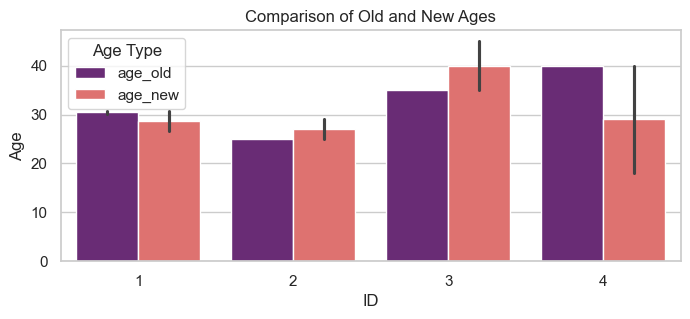

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame
data = updated_df

df_plotted = pd.DataFrame(data)

# Melt DataFrame for easy plotting
melted_df = df_plotted.melt(id_vars=['id'], value_vars=['age_old', 'age_new'], 
                    var_name='Age Type', value_name='Age')

# Plotting
plt.figure(figsize=(8, 3))
sns.barplot(x='id', y='Age', hue='Age Type', data=melted_df, palette='magma')
plt.title('Comparison of Old and New Ages')
plt.xlabel('ID')
plt.ylabel('Age')
plt.show()
